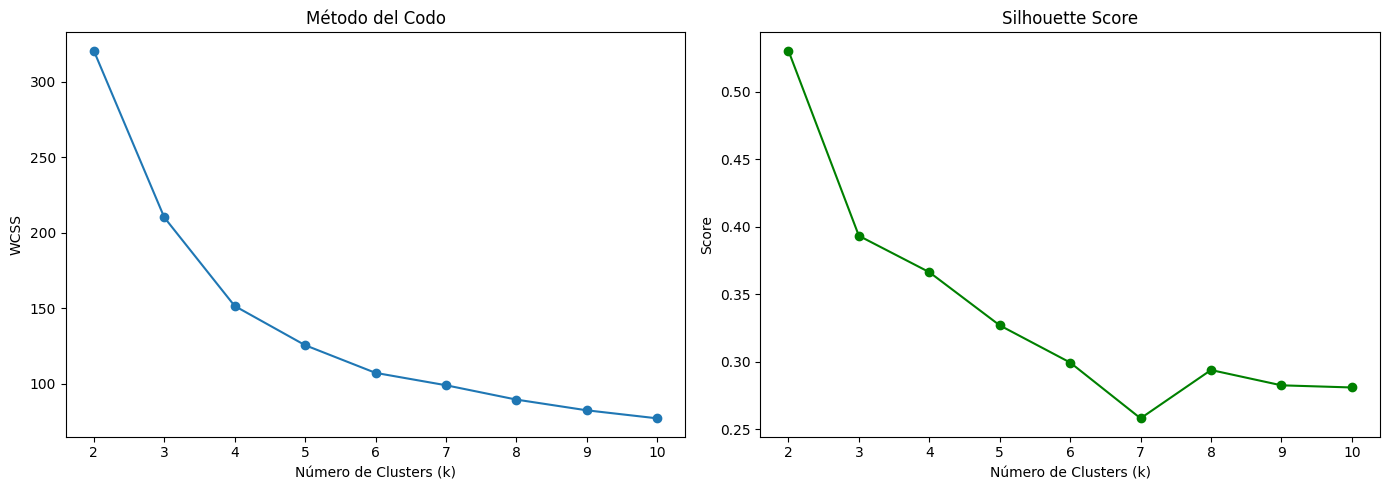

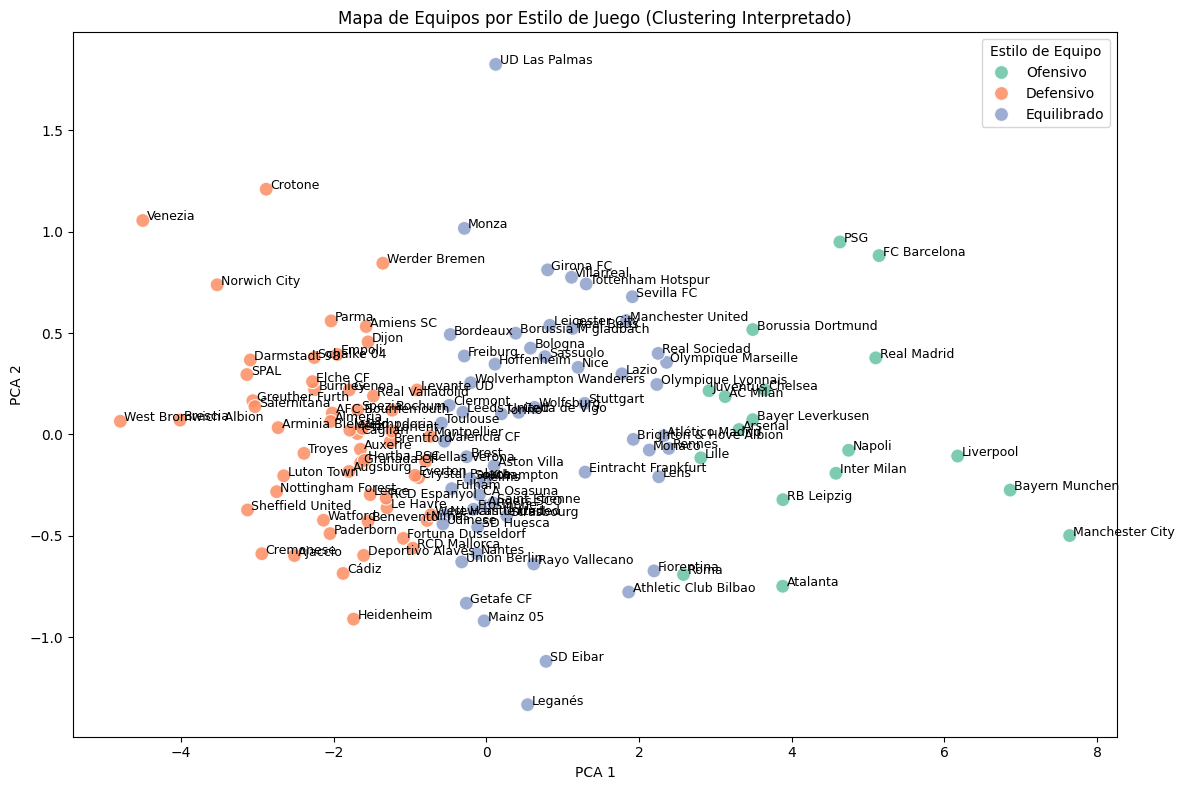

✅ Archivo guardado como: equipos_por_cluster.xlsx


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

df_refined = pd.read_excel("/content/dataset final estandarizado.xlsx")

df_local = df_refined[[
    "home_team_name", "xg_diff", "possession_diff", "shots_diff",
    "shots_on_target_diff", "corner_diff", "elo_difference"
]].copy()
df_local = df_local.rename(columns={"home_team_name": "team"})

df_away = df_refined[[
    "away_team_name", "xg_diff", "possession_diff", "shots_diff",
    "shots_on_target_diff", "corner_diff", "elo_difference"
]].copy()
df_away = df_away.rename(columns={"away_team_name": "team"})
df_away[["xg_diff", "possession_diff", "shots_diff", "shots_on_target_diff", "corner_diff", "elo_difference"]] *= -1

df_combined = pd.concat([df_local, df_away], axis=0)

df_team_profile = df_combined.groupby("team").mean(numeric_only=True).reset_index()

X = df_team_profile.drop(columns=["team"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss, silhouette_scores = [], []
for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    wcss.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, model.labels_))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(range(2, 11), wcss, marker='o')
ax[0].set_title("Método del Codo")
ax[0].set_xlabel("Número de Clusters (k)")
ax[0].set_ylabel("WCSS")

ax[1].plot(range(2, 11), silhouette_scores, marker='o', color="green")
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Número de Clusters (k)")
ax[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
df_team_profile["cluster"] = kmeans.fit_predict(X_scaled)

cluster_means = df_team_profile.groupby("cluster")[["xg_diff", "shots_diff", "possession_diff"]].mean()
orden = cluster_means.mean(axis=1).sort_values(ascending=False).index.tolist()

cluster_nombres_map = {
    orden[0]: "Ofensivo",
    orden[1]: "Equilibrado",
    orden[2]: "Defensivo"
}
df_team_profile["cluster_nombre"] = df_team_profile["cluster"].map(cluster_nombres_map)

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)
df_team_profile["PCA1"] = pca_coords[:, 0]
df_team_profile["PCA2"] = pca_coords[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_team_profile,
    x="PCA1", y="PCA2",
    hue="cluster_nombre",
    palette="Set2",
    s=100, alpha=0.85
)

for _, row in df_team_profile.iterrows():
    plt.text(row["PCA1"] + 0.05, row["PCA2"], row["team"], fontsize=9)

plt.title("Mapa de Equipos por Estilo de Juego (Clustering Interpretado)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Estilo de Equipo")
plt.tight_layout()
plt.show()

df_team_profile[["team", "cluster", "cluster_nombre"]].to_excel("equipos_por_cluster.xlsx", index=False)
print("✅ Archivo guardado como: equipos_por_cluster.xlsx")



In [2]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

df = pd.read_excel("/content/dataset final estandarizado.xlsx")
clusters_df = pd.read_excel("/content/equipos_por_cluster.xlsx")
cluster_map = clusters_df.set_index("team")["cluster"].to_dict()
df["home_team_cluster"] = df["home_team_name"].map(cluster_map)
df["away_team_cluster"] = df["away_team_name"].map(cluster_map)

df["abs_elo_diff"] = df["elo_difference"].abs()
df["abs_xg_diff"] = df["xg_diff"].abs()
df["abs_odds_diff"] = abs(df["odds_ft_home_team_win"] - df["odds_ft_away_team_win"])
df["draw_prob"] = df["odds_ft_draw"] / (
    df["odds_ft_home_team_win"] + df["odds_ft_away_team_win"] + df["odds_ft_draw"]
)

features = [
    "elo_difference", "xg_diff", "shots_diff", "shots_on_target_diff", "possession_diff",
    "corner_diff", "fouls_diff", "yellow_cards_diff",
    "home_team_encoded", "away_team_encoded", "comp_encoded",
    "home_team_cluster", "away_team_cluster",
    "abs_elo_diff", "abs_xg_diff", "abs_odds_diff", "draw_prob"
]
X = df[features]
y = df["match_result"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, random_state=42)

model = RandomForestClassifier(
    n_estimators=300, max_depth=20, class_weight={0: 3, 1: 1, 2: 1}, random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Empate", "Victoria Local", "Victoria Visitante"]))

                    precision    recall  f1-score   support

            Empate       0.61      0.65      0.63       965
    Victoria Local       0.72      0.68      0.70       965
Victoria Visitante       0.74      0.73      0.74       966

          accuracy                           0.69      2896
         macro avg       0.69      0.69      0.69      2896
      weighted avg       0.69      0.69      0.69      2896



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:04:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4060
[LightGBM] [Info] Number of data points in the train set: 9266, number of used features: 17
[LightGBM] [Info] Start training from score -1.098504
[LightGBM] [Info] Start training from score -1.098504
[LightGBM] [Info] Start training from score -1.098828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


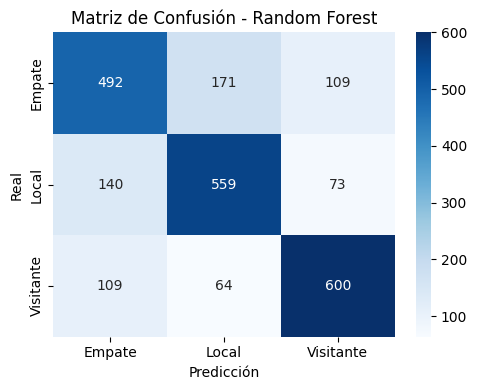

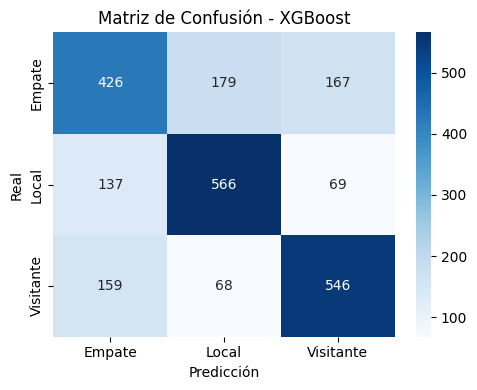

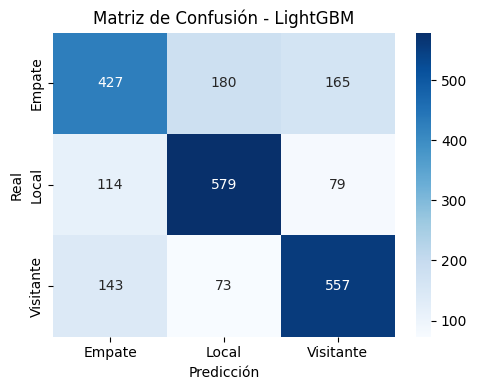

ModuleNotFoundError: No module named 'ace_tools'

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("/content/dataset final estandarizado.xlsx")
clusters_df = pd.read_excel("/content/equipos_por_cluster.xlsx")
cluster_map = clusters_df.set_index("team")["cluster"].to_dict()
df["home_team_cluster"] = df["home_team_name"].map(cluster_map)
df["away_team_cluster"] = df["away_team_name"].map(cluster_map)

df["abs_elo_diff"] = df["elo_difference"].abs()
df["abs_xg_diff"] = df["xg_diff"].abs()
df["abs_odds_diff"] = abs(df["odds_ft_home_team_win"] - df["odds_ft_away_team_win"])
df["draw_prob"] = df["odds_ft_draw"] / (
    df["odds_ft_home_team_win"] + df["odds_ft_away_team_win"] + df["odds_ft_draw"]
)

features = [
    "elo_difference", "xg_diff", "shots_diff", "shots_on_target_diff",
    "possession_diff", "corner_diff", "fouls_diff", "yellow_cards_diff",
    "home_team_encoded", "away_team_encoded", "comp_encoded",
    "home_team_cluster", "away_team_cluster",
    "abs_odds_diff", "draw_prob", "abs_elo_diff", "abs_xg_diff"
]
target = "match_result"

X = df[features]
y = df[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=20, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, objective="multi:softmax",
                             num_class=3, use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                               objective="multiclass", num_class=3, is_unbalance=True, random_state=42)
}

results = []
matrices = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Modelo": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_macro": f1_score(y_test, y_pred, average="macro"),
        "F1_Empate": f1_score(y_test, y_pred, average=None)[0],
        "F1_Local": f1_score(y_test, y_pred, average=None)[1],
        "F1_Visitante": f1_score(y_test, y_pred, average=None)[2]
    })

    matrices[name] = confusion_matrix(y_test, y_pred)

df_resultados = pd.DataFrame(results)

for name, cm in matrices.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Empate", "Local", "Visitante"], yticklabels=["Empate", "Local", "Visitante"])
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

import ace_tools as tools; tools.display_dataframe_to_user(name="Resultados Métricas", dataframe=df_resultados)

In [4]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

df = pd.read_excel("/content/dataset final estandarizado.xlsx")
clusters_df = pd.read_excel("/content/equipos_por_cluster.xlsx")
cluster_map = clusters_df.set_index("team")["cluster"].to_dict()
df["home_team_cluster"] = df["home_team_name"].map(cluster_map)
df["away_team_cluster"] = df["away_team_name"].map(cluster_map)

df["abs_elo_diff"] = df["elo_difference"].abs()
df["abs_xg_diff"] = df["xg_diff"].abs()
df["abs_odds_diff"] = abs(df["odds_ft_home_team_win"] - df["odds_ft_away_team_win"])
df["draw_prob"] = df["odds_ft_draw"] / (
    df["odds_ft_home_team_win"] + df["odds_ft_away_team_win"] + df["odds_ft_draw"]
)

features = [
    "elo_difference", "xg_diff", "shots_diff", "shots_on_target_diff", "possession_diff",
    "corner_diff", "fouls_diff", "yellow_cards_diff",
    "home_team_encoded", "away_team_encoded", "comp_encoded",
    "home_team_cluster", "away_team_cluster",
    "abs_elo_diff", "abs_xg_diff", "abs_odds_diff", "draw_prob"
]
X = df[features]
y = df["match_result"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, random_state=42)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print("🚀 Resultados XGBoost:")
print(classification_report(y_test, y_pred, target_names=["Empate", "Victoria Local", "Victoria Visitante"]))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:04:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🚀 Resultados XGBoost:
                    precision    recall  f1-score   support

            Empate       0.60      0.56      0.58       965
    Victoria Local       0.70      0.73      0.71       965
Victoria Visitante       0.71      0.72      0.71       966

          accuracy                           0.67      2896
         macro avg       0.67      0.67      0.67      2896
      weighted avg       0.67      0.67      0.67      2896



In [5]:
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

df = pd.read_excel("/content/dataset final estandarizado.xlsx")
clusters_df = pd.read_excel("/content/equipos_por_cluster.xlsx")
cluster_map = clusters_df.set_index("team")["cluster"].to_dict()
df["home_team_cluster"] = df["home_team_name"].map(cluster_map)
df["away_team_cluster"] = df["away_team_name"].map(cluster_map)

df["abs_elo_diff"] = df["elo_difference"].abs()
df["abs_xg_diff"] = df["xg_diff"].abs()
df["abs_odds_diff"] = abs(df["odds_ft_home_team_win"] - df["odds_ft_away_team_win"])
df["draw_prob"] = df["odds_ft_draw"] / (
    df["odds_ft_home_team_win"] + df["odds_ft_away_team_win"] + df["odds_ft_draw"]
)

features = [
    "elo_difference", "xg_diff", "shots_diff", "shots_on_target_diff", "possession_diff",
    "corner_diff", "fouls_diff", "yellow_cards_diff",
    "home_team_encoded", "away_team_encoded", "comp_encoded",
    "home_team_cluster", "away_team_cluster",
    "abs_elo_diff", "abs_xg_diff", "abs_odds_diff", "draw_prob"
]
X = df[features]
y = df["match_result"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, random_state=42)

lgbm_model = LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    objective="multiclass",
    num_class=3,
    is_unbalance=True,
    random_state=42
)
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)

print("🌿 Resultados LightGBM:")
print(classification_report(y_test, y_pred, target_names=["Empate", "Victoria Local", "Victoria Visitante"]))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4055
[LightGBM] [Info] Number of data points in the train set: 8687, number of used features: 17
[LightGBM] [Info] Start training from score -1.098497
[LightGBM] [Info] Start training from score -1.098497
[LightGBM] [Info] Start training from score -1.098843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🌿 Resultados LightGBM:
                    precision    recall  f1-score   support

            Empate       0.60      0.56      0.58       965
    Victoria Local       0.69      0.73      0.71       965
Victoria Visitante       0.71      0.71      0.71       966

          accuracy                           0.67      2896
         macro avg       0.67      0.67      0.67      2896
      weighted avg       0.67      0.67      0.67      2896



<ipython-input-6-1319851494>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importance_df, palette='viridis')


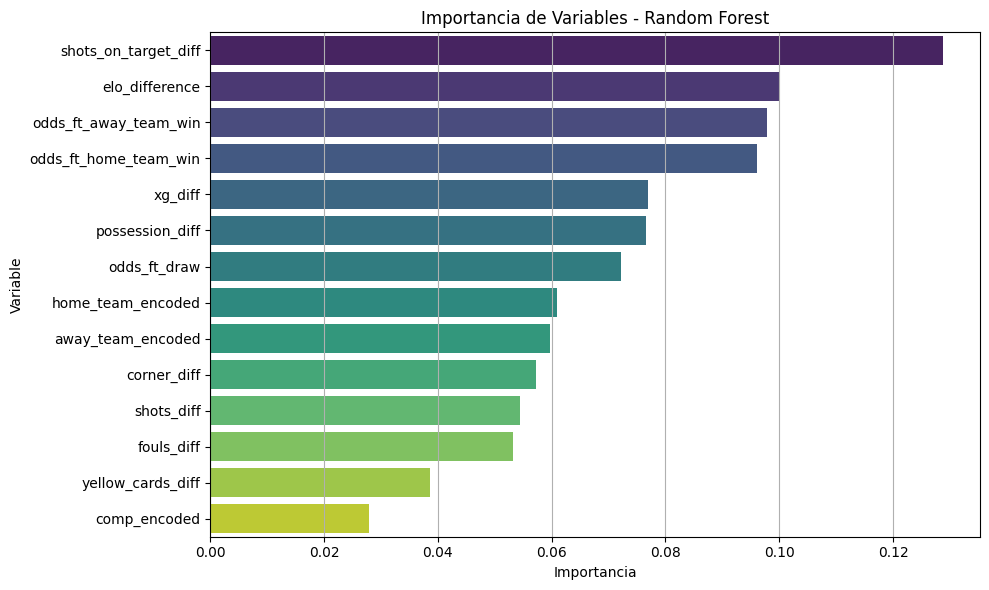

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

df = pd.read_excel('/content/dataset tfg copia.xlsx')

y = df['match_result']

X = df.drop(columns=[
    'date_GMT', 'home_team_name', 'away_team_name', 'Comp', 'match_result'
])

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

importances = rf_model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'Variable': features,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=importance_df, palette='viridis')
plt.title('Importancia de Variables - Random Forest')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

df = pd.read_excel("/content/resultados_predichos_rf_2024_2025.xlsx")

variables_diff = [
    "elo_difference", "xg_diff", "shots_diff", "shots_on_target_diff",
    "possession_diff", "corner_diff", "fouls_diff", "yellow_cards_diff"
]

for var in variables_diff:
    df[f"{var}_home"] = df[var] / 2
    df[f"{var}_away"] = -df[var] / 2

output_path = "partidos_estadisticas_desglosadas_final.xlsx"
df.to_excel(output_path, index=False)

print(f"✅ Archivo guardado: {output_path}")

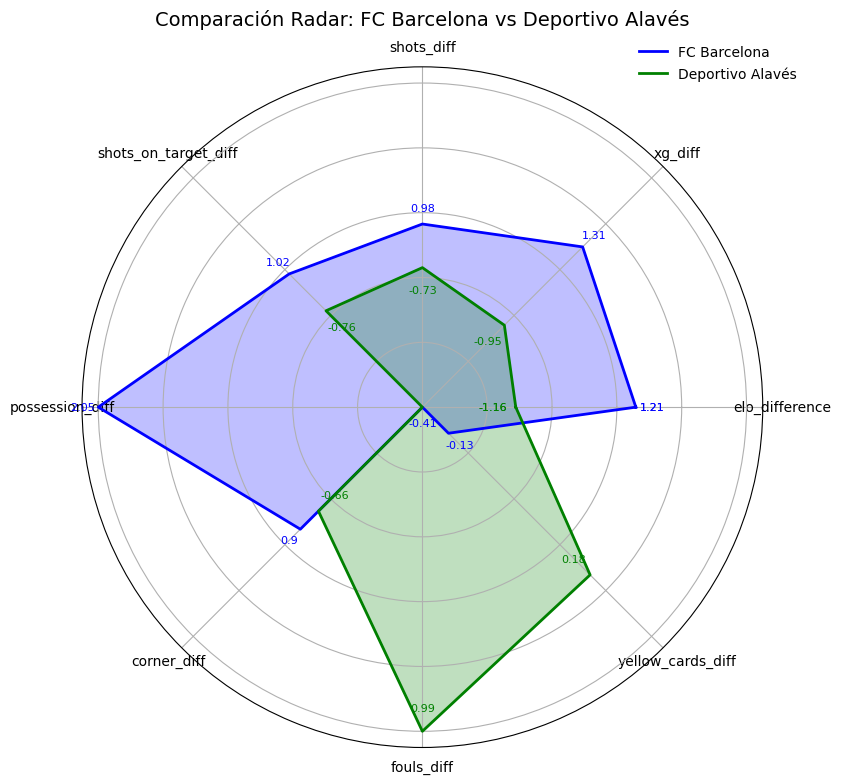

In [7]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['elo_difference', 'xg_diff', 'shots_diff', 'shots_on_target_diff',
          'possession_diff', 'corner_diff', 'fouls_diff', 'yellow_cards_diff']

stats_barcelona = [1.21, 1.31, 0.98, 1.02, 2.05, 0.9, -0.41, -0.13]
stats_alaves = [-1.16, -0.95, -0.73, -0.76, -2.03, -0.66, 0.99, 0.18]

def normalize(data):
    min_val = min(data)
    max_val = max(data)
    return [(x - min_val) / (max_val - min_val) if max_val != min_val else 0.5 for x in data]

barcelona_norm = normalize(stats_barcelona)
alaves_norm = normalize(stats_alaves)

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
barcelona_norm += barcelona_norm[:1]
alaves_norm += alaves_norm[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

ax.plot(angles, barcelona_norm, color='blue', linewidth=2, label='FC Barcelona')
ax.fill(angles, barcelona_norm, color='blue', alpha=0.25)

ax.plot(angles, alaves_norm, color='green', linewidth=2, label='Deportivo Alavés')
ax.fill(angles, alaves_norm, color='green', alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticklabels([])
ax.set_title("Comparación Radar: FC Barcelona vs Deportivo Alavés", pad=30, fontsize=14)

for angle, value, val_txt in zip(angles, barcelona_norm, stats_barcelona + stats_barcelona[:1]):
    ax.text(angle, value + 0.05, str(val_txt), color='blue', ha='center', va='center', fontsize=8)

for angle, value, val_txt in zip(angles, alaves_norm, stats_alaves + stats_alaves[:1]):
    ax.text(angle, value - 0.07, str(val_txt), color='green', ha='center', va='center', fontsize=8)

ax.legend(loc='upper left', bbox_to_anchor=(0.8, 1.05), fontsize=10, frameon=False)

plt.tight_layout(pad=3.0)
plt.show()

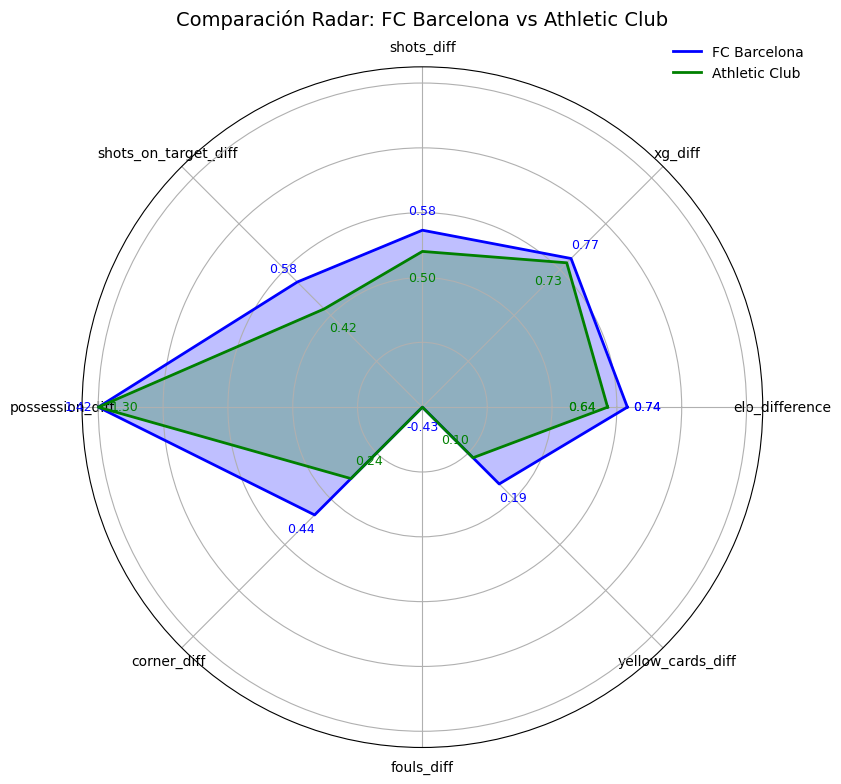

In [8]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['elo_difference', 'xg_diff', 'shots_diff', 'shots_on_target_diff',
          'possession_diff', 'corner_diff', 'fouls_diff', 'yellow_cards_diff']

stats_barcelona = [0.74, 0.77, 0.58, 0.58, 1.42, 0.44, -0.43, 0.19]
stats_athletic = [0.64, 0.73, 0.5, 0.42, 1.3, 0.24, -0.24, 0.1]

def normalize(data):
    min_val = min(data)
    max_val = max(data)
    return [(x - min_val) / (max_val - min_val) if max_val != min_val else 0.5 for x in data]

barcelona_norm = normalize(stats_barcelona)
athletic_norm = normalize(stats_athletic)

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
barcelona_norm += barcelona_norm[:1]
athletic_norm += athletic_norm[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

ax.set_yticklabels([])

ax.plot(angles, barcelona_norm, color='blue', linewidth=2, label='FC Barcelona')
ax.fill(angles, barcelona_norm, color='blue', alpha=0.25)

ax.plot(angles, athletic_norm, color='green', linewidth=2, label='Athletic Club')
ax.fill(angles, athletic_norm, color='green', alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_title("Comparación Radar: FC Barcelona vs Athletic Club", pad=30, fontsize=14)


for angle, value, val_txt in zip(angles, barcelona_norm, stats_barcelona + stats_barcelona[:1]):
    ax.text(angle, value + 0.06, f"{val_txt:.2f}", color='blue', ha='center', va='center', fontsize=9)

for angle, value, val_txt in zip(angles, athletic_norm, stats_athletic + stats_athletic[:1]):
    ax.text(angle, value - 0.08, f"{val_txt:.2f}", color='green', ha='center', va='center', fontsize=9)

ax.legend(loc='upper left', bbox_to_anchor=(0.85, 1.05), fontsize=10, frameon=False)

plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

df_hist = pd.read_excel("/content/dataset_limpio_estandarizado.xlsx")
df_clusters = pd.read_excel("/content/equipos_por_cluster.xlsx")
df_futuro = pd.read_excel("/content/partidos 2024-2025.xlsx")

cluster_map = df_clusters.set_index("team")["cluster"].to_dict()
df_hist["home_team_cluster"] = df_hist["home_team_name"].map(cluster_map)
df_hist["away_team_cluster"] = df_hist["away_team_name"].map(cluster_map)
df_futuro["home_team_cluster"] = df_futuro["home_team_name"].map(cluster_map)
df_futuro["away_team_cluster"] = df_futuro["away_team_name"].map(cluster_map)

estadisticas = [
    "elo_difference", "xg_diff", "shots_diff", "shots_on_target_diff",
    "possession_diff", "corner_diff", "fouls_diff", "yellow_cards_diff",
    "odds_ft_home_team_win", "odds_ft_away_team_win", "odds_ft_draw"
]

df_home = df_hist[["home_team_name"] + estadisticas].copy()
df_home.columns = ["team"] + estadisticas

df_away = df_hist[["away_team_name"] + estadisticas].copy()
df_away.columns = ["team"] + estadisticas
df_away[estadisticas] *= -1

avg_home = df_home.groupby("team").mean(numeric_only=True)
avg_away = df_away.groupby("team").mean(numeric_only=True)

def simular_estadistica(row, var):
    home = row["home_team_name"]
    away = row["away_team_name"]
    h_val = avg_home.loc[home, var] if home in avg_home.index else 0
    a_val = avg_away.loc[away, var] if away in avg_away.index else 0
    return h_val - a_val

for var in estadisticas:
    df_futuro[var] = df_futuro.apply(lambda row: simular_estadistica(row, var), axis=1)

df_hist["abs_elo_diff"] = df_hist["elo_difference"].abs()
df_hist["abs_xg_diff"] = df_hist["xg_diff"].abs()
df_hist["abs_odds_diff"] = abs(df_hist["odds_ft_home_team_win"] - df_hist["odds_ft_away_team_win"])
df_hist["draw_prob"] = df_hist["odds_ft_draw"] / (
    df_hist["odds_ft_home_team_win"] + df_hist["odds_ft_away_team_win"] + df_hist["odds_ft_draw"]
)

df_futuro["abs_elo_diff"] = df_futuro["elo_difference"].abs()
df_futuro["abs_xg_diff"] = df_futuro["xg_diff"].abs()
df_futuro["abs_odds_diff"] = abs(df_futuro["odds_ft_home_team_win"] - df_futuro["odds_ft_away_team_win"])
df_futuro["draw_prob"] = df_futuro["odds_ft_draw"] / (
    df_futuro["odds_ft_home_team_win"] + df_futuro["odds_ft_away_team_win"] + df_futuro["odds_ft_draw"]
)

features = [
    "elo_difference", "xg_diff", "shots_diff", "shots_on_target_diff", "possession_diff",
    "corner_diff", "fouls_diff", "yellow_cards_diff",
    "home_team_encoded", "away_team_encoded", "comp_encoded",
    "home_team_cluster", "away_team_cluster",
    "abs_elo_diff", "abs_xg_diff", "abs_odds_diff", "draw_prob"
]
target = "match_result"

X = df_hist[features]
y = df_hist[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)


rf = RandomForestClassifier(n_estimators=300, max_depth=20, class_weight={0: 3, 1: 1, 2: 1}, random_state=42)
rf.fit(X_resampled, y_resampled)

X_pred = df_futuro[features]
X_pred_scaled = scaler.transform(X_pred)
df_futuro["predicted_result"] = rf.predict(X_pred_scaled)
df_futuro["predicted_label"] = df_futuro["predicted_result"].map({
    0: "Empate", 1: "Victoria Local", 2: "Victoria Visitante"
})

output_path = "resultados_predichos_rf_2024_2025.xlsx"
df_futuro.to_excel(output_path, index=False)
print(f"✅ Archivo exportado: {output_path}")


In [ ]:
import pandas as pd

df = pd.read_excel("/content/resultados_predichos_rf_2024_2025.xlsx")

if "comp_encoded" not in df.columns:
    raise ValueError("❌ Falta la columna 'Comp' para identificar las ligas.")

ligas = df["comp_encoded"].unique()
clasificaciones = {}

for liga in ligas:
    df_liga = df[df["comp_encoded"] == liga]

    equipos = pd.unique(df_liga[["home_team_name", "away_team_name"]].values.ravel())
    tabla = {equipo: {"Equipo": equipo, "PJ": 0, "PG": 0, "PE": 0, "PP": 0, "Puntos": 0} for equipo in equipos}

    for _, row in df_liga.iterrows():
        home = row["home_team_name"]
        away = row["away_team_name"]
        result = row["predicted_result"]


        tabla[home]["PJ"] += 1
        tabla[away]["PJ"] += 1


        if result == 0:
            tabla[home]["PE"] += 1
            tabla[away]["PE"] += 1
            tabla[home]["Puntos"] += 1
            tabla[away]["Puntos"] += 1
        elif result == 1:
            tabla[home]["PG"] += 1
            tabla[away]["PP"] += 1
            tabla[home]["Puntos"] += 3
        elif result == 2:
            tabla[away]["PG"] += 1
            tabla[home]["PP"] += 1
            tabla[away]["Puntos"] += 3


    df_clas = pd.DataFrame.from_dict(tabla, orient="index")
    df_clas = df_clas.sort_values(by=["Puntos", "PG"], ascending=False).reset_index(drop=True)
    clasificaciones[liga] = df_clas


output_clasif = "clasificaciones_2024_2025_rf.xlsx"

with pd.ExcelWriter(output_clasif) as writer:
    for liga, tabla in clasificaciones.items():
        nombre_hoja = str(liga)[:31] if isinstance(liga, str) else f"Liga_{liga}"
        tabla.to_excel(writer, sheet_name=nombre_hoja, index=False)

print(f"✅ Clasificaciones por liga guardadas en '{output_clasif}'")